In [2]:
!pip install bayesian-optimization

  Running setup.py bdist_wheel for bayesian-optimization ... - done
  Stored in directory: /root/.cache/pip/wheels/4b/60/a2/6eec4adc73341c1a2a653022b99ff8e1cb090684dba83be683
Successfully built bayesian-optimization


In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving GOOG-year.csv to GOOG-year.csv
User uploaded file "GOOG-year.csv" with length 18678 bytes


In [8]:
df = pd.read_csv('GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [0]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = w + self.learning_rate/(self.population_size * self.sigma) * np.dot(A.T, rewards).T
            if (i+1) % print_every == 0:
                print('iter %d. reward: %f' %  (i+1, self.reward_function(self.weights)))
        print('time taken to train:', time.time()-lasttime, 'seconds')
        
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [np.random.randn(input_size, layer_size), 
                        np.random.randn(layer_size, output_size),
                        np.random.randn(layer_size, 1),
                        np.random.randn(1, layer_size)]
    
    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy
    
    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    
    def __init__(self, population_size, sigma, learning_rate, model, money, max_buy, max_sell, skip, window_size):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(self.model.get_weights(), self.get_reward, self.POPULATION_SIZE, self.SIGMA, self.LEARNING_RATE)
    
    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])
    
    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0,l,self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                
            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100
    
    def fit(self, iterations, checkpoint):
        self.es.train(iterations,print_every=checkpoint)
        
    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0,l,self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print('day %d: buy %d units at price %f, total balance %f'%(t,buy_units, total_buy,initial_money))
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('day %d, sell %d units at price %f, investment %f %%, total balance %f,'%(t, sell_units, total_sell, invest, initial_money))
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        print('\ntotal gained %f, total investment %f %%'%(initial_money - starting_money,invest))
        plt.figure(figsize=(20,10))
        plt.plot(close, label='true close',c='g')
        plt.plot(close, 'X', label='predict buy',markevery=states_buy, c='b')
        plt.plot(close, 'o', label='predict sell',markevery=states_sell,c='r')
        plt.legend()
        plt.show()

In [0]:
def best_agent(window_size, skip, population_size, sigma, learning_rate, size_network):
    model = Model(window_size, size_network, 3)
    agent = Agent(population_size, sigma, learning_rate,model,10000,5,5,skip,window_size)
    try:
        agent.fit(10, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [0]:
def find_best_agent(window_size, skip, population_size, sigma, learning_rate, size_network):
    global accbest
    param = {
        'window_size' : int(np.around(window_size)),
        'skip' : int(np.around(skip)),
        'population_size' : int(np.around(population_size)),
        'sigma' : max(min(sigma, 1), 0.0001),
        'learning_rate' : max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network))
    }
    print("\nSearch parameters %s" % (param))
    investment = best_agent(**param)
    print("stop after 100 iteration with investment %f" % (investment))
    if (investment > accbest):
        costbest = investment
    return investment

In [14]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(find_best_agent, 
                              {'window_size': (2, 50),
                               'skip': (1, 15),
                               'population_size': (1, 50),
                               'sigma': (0.01, 0.99),
                               'learning_rate': (0.000001, 0.49),
                               'size_network': (10,1000)
                              })
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 48, 'skip': 4, 'population_size': 22, 'sigma': 0.10708266110522625, 'learning_rate': 0.03743162098095896, 'size_network': 605}
time taken to train: 1.1136584281921387 seconds
stop after 100 iteration with investment 28.081556
|  1        |  28.08    |  0.03743  |  21.8     |  0.1071   |  605.1    |  3.957    |  47.98    |

Search parameters {'window_size': 37, 'skip': 6, 'population_size': 14, 'sigma': 0.11220774434199365, 'learning_rate': 0.43951642757160353, 'size_network': 329}
time taken to train: 0.37421560287475586 seconds
stop after 100 iteration with investment 28.522900
|  2        |  28.52    |  0.4395   |  14.16    |  0.1122   |  328.5    |  5.675    |  37.23    |

Search parameters {'window_size': 44, 'skip': 13, 'population_size': 34, 'sigma': 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


time taken to train: 0.9271721839904785 seconds
stop after 100 iteration with investment -9.162098
|  19       | -9.162    |  0.05028  |  42.67    |  0.3899   |  550.6    |  11.13    |  19.75    |

Search parameters {'window_size': 34, 'skip': 13, 'population_size': 8, 'sigma': 0.04975466132168294, 'learning_rate': 0.3428273078762872, 'size_network': 910}
stop after 100 iteration with investment 0.000000
|  20       |  0.0      |  0.3428   |  8.182    |  0.04975  |  910.1    |  12.83    |  33.71    |

Search parameters {'window_size': 33, 'skip': 14, 'population_size': 41, 'sigma': 0.26174695619934524, 'learning_rate': 0.11390902832267505, 'size_network': 212}
time taken to train: 0.40258359909057617 seconds
stop after 100 iteration with investment 9.914001
|  21       |  9.914    |  0.1139   |  40.9     |  0.2617   |  211.6    |  13.74    |  32.52    |

Search parameters {'window_size': 28, 'skip': 6, 'population_size': 44, 'sigma': 0.16135484584283885, 'learning_rate': 0.232176743359

In [15]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

TypeError: ignored

In [16]:
# this is my parameter
best_agent(30,1,15,0.1,0.03,500)

time taken to train: 1.7558412551879883 seconds


33.40414282000003

In [17]:
# this is from bayesian
best_agent(35,2,26,0.10090224935146827,0.265723963860465,587)

time taken to train: 2.204678535461426 seconds


-0.33890260000003763

iter 100. reward: 43.322598
iter 200. reward: 58.439301
iter 300. reward: 60.141201
iter 400. reward: 63.493756
iter 500. reward: 71.981249
time taken to train: 112.05599331855774 seconds
day 2: buy 5 units at price 3810.100100, total balance 6189.899900
day 3: buy 1 units at price 782.520020, total balance 5407.379880
day 5, sell 5 units at price 3926.549990, investment 3.056347 %, total balance 9333.929870,
day 6, sell 1 units at price 762.559998, investment -2.550736 %, total balance 10096.489868,
day 7: buy 5 units at price 3770.100100, total balance 6326.389768
day 8: buy 5 units at price 3680.400085, total balance 2645.989683
day 9: buy 5 units at price 3792.449950, total balance -1146.460267
day 11, sell 5 units at price 3856.149900, investment 2.282427 %, total balance 2709.689633,
day 12, sell 5 units at price 3802.699890, investment 3.323003 %, total balance 6512.389523,
day 13, sell 5 units at price 3846.000060, investment 1.412019 %, total balance 10358.389583,
day 16: buy 

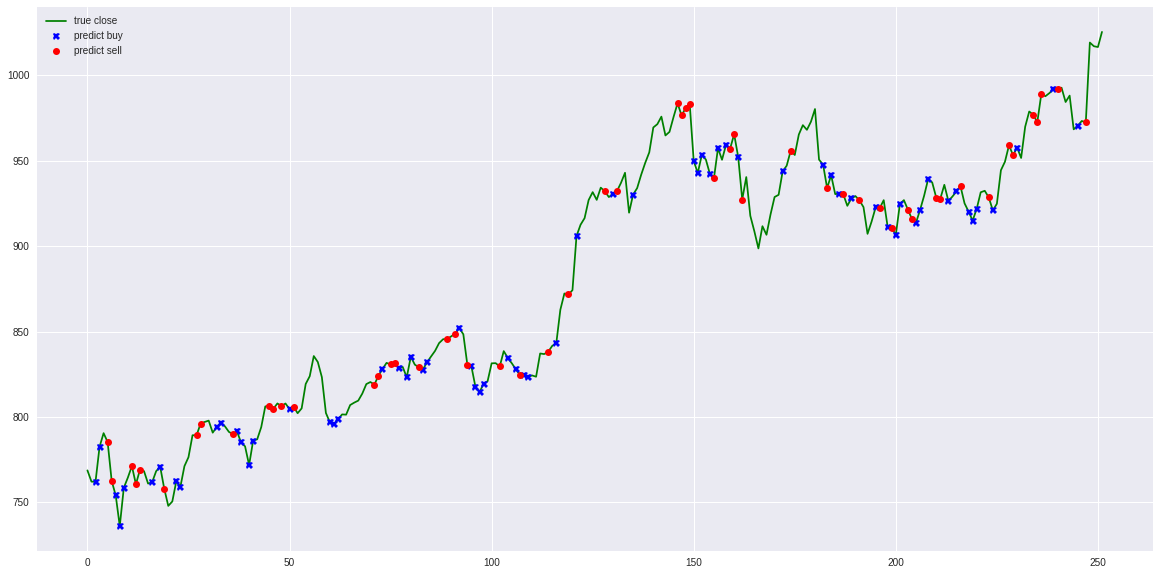

In [18]:
# this is my parameter
model = Model(30, 500, 3)
agent = Agent(15, 0.1, 0.03,model,10000,5,5,1,30)
agent.fit(500, 100)
agent.buy()

iter 100. reward: 37.873605
iter 200. reward: 47.390705
iter 300. reward: 40.379566
iter 400. reward: 52.305165
iter 500. reward: 34.445568
time taken to train: 215.81143140792847 seconds
day 0: buy 5 units at price 3843.500060, total balance 6156.499940
day 2: buy 5 units at price 3810.100100, total balance 2346.399840
day 3, sell 5 units at price 3912.600100, investment 1.797842 %, total balance 6258.999940,
day 4, sell 5 units at price 3952.550050, investment 3.738746 %, total balance 10211.549990,
day 7: buy 1 units at price 754.020020, total balance 9457.529970
day 8: buy 5 units at price 3680.400085, total balance 5777.129885
day 9: buy 5 units at price 3792.449950, total balance 1984.679935
day 11, sell 5 units at price 3856.149900, investment 411.412137 %, total balance 5840.829835,
day 13, sell 5 units at price 3846.000060, investment 4.499510 %, total balance 9686.829895,
day 15: buy 5 units at price 3804.949950, total balance 5881.879945
day 16: buy 5 units at price 3808.399

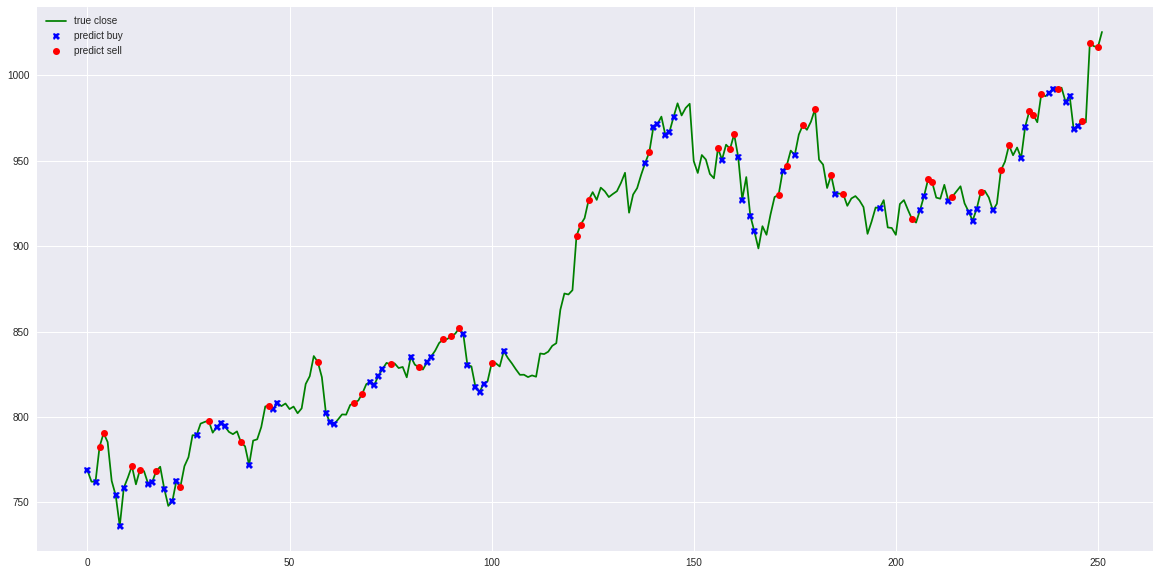

In [22]:
# this is from bayesian
model = Model(35, 587, 3)
agent = Agent(26, 0.10090224935146827, 0.265723963860465,model,10000,5,5,1,35)
agent.fit(500, 100)
agent.buy()